In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
path = 'data_with_momentum/2023-wimbledon-1701.csv'
df = pd.read_csv(path)

In [3]:
"""
计算综合势头得分函数
"""
def calculate_comprehensive_momentum(data, player_number, window_size=4):
    momentum_scores = [0] * len(data)
    consecutive_point_wins = 0  # 追踪连续得分
    consecutive_game_wins = 0  # 追踪连续获胜的局数
    previous_game_winner = None  # 追踪上一局的获胜者
    initial_break_point_value = 1  # 破发的基础势头得分增加值

    for i in range(1, len(data)):
        recent_data = data[max(0, i - window_size):i]
        momentum_score = 0

        for _, feature in recent_data.iterrows():
            # 基本的势头得分计算
            P_t = 1 if feature['point_victor'] == player_number else -1
            S_t = 1.2 if feature['server'] == player_number else 1.0
            base_momentum = P_t * S_t
            momentum_score += base_momentum
            break_point_value = initial_break_point_value  # 重置破发得分值

            # 连续得分补正（线性）
            if P_t == 1:
                consecutive_point_wins += 1
            else:
                consecutive_point_wins = 0  # 在失分时重置
            momentum_score += 0.03 * consecutive_point_wins  # 每连续获胜增加额外得分

            # 连续小局获胜补正（线性）
            if feature['game_victor']:
                current_game_winner = feature['game_victor']
                if current_game_winner == player_number:
                    if current_game_winner == previous_game_winner:
                        consecutive_game_wins += 1
                    else:
                        consecutive_game_wins = 0  # 重置连续获胜局数
                previous_game_winner = current_game_winner
                momentum_score += 0.2 * consecutive_game_wins  # 连续获胜局数的影响

            # 大比分差距补正（指数）
            if feature['set_victor']:
                player1_set = feature['p1_sets'] + 1 if feature['set_victor'] == player_number else feature['p1_sets']
                player2_set = feature['p2_sets'] + 1 if feature['set_victor'] == player_number else feature['p2_sets']
                diff = (player2_set - player1_set) * (-1 ** player_number)  # player1为-1， player2为+1
                momentum_score += 0.1 * (2 ** diff)

            # 小比分差距补正（线性）
            if feature['game_victor']:
                score_diff = abs(feature['p1_games'] - feature['p2_games'])
                momentum_score += 0.02 * score_diff * P_t

            # 错失破发点对破发的势头得分增加值的削弱
            if feature['p1_break_pt_missed'] == 1 or feature['p2_break_pt_missed'] == 1:
                break_point_value -= 0.1  # 削弱的权值

            # (被)破发的影响
            if feature['p1_break_pt_won'] == 1 or feature['p2_break_pt_won'] == 1:
                break_point_value = max(break_point_value, 0.1)
                momentum_score += break_point_value * P_t

            # 拍数和跑动距离的影响
            rally_factor = feature['rally_count'] / 30  # 归一化回合数
            distance_factor = (feature['p1_distance_run'] + feature['p2_distance_run']) / 122  # 归一化跑动距离
            momentum_score += 2.0 * rally_factor * distance_factor * P_t

        momentum_scores[i] = momentum_score

    return momentum_scores

In [4]:
"""
随机比赛模拟函数
"""
def simulate_comprehensive_momentum(num_points, player_number, serve_win_prob=0.65, window_size=4):
    """
    模拟网球比赛的势头得分情况。
    :param num_points: 比赛中的总得分点数
    :param player_number: 玩家编号 (1 或 2)
    :param serve_win_prob: 发球方获胜概率
    :param window_size: 考虑的窗口大小
    :return: 势头得分列表
    """
    # 初始化模拟数据
    simulated_data = pd.DataFrame({
        'point_victor': np.random.choice([1, 2], size=num_points, p=[serve_win_prob, 1 - serve_win_prob]),
        'server': np.random.choice([1, 2], size=num_points),
        'game_victor': None,  # 模拟中不具体计算
        'set_victor': None,  # 模拟中不具体计算
        'p1_sets': 0, 'p2_sets': 0, 'p1_games': 0, 'p2_games': 0,  # 模拟中不具体计算
        'p1_break_pt_missed': np.random.choice([0, 1], size=num_points),
        'p2_break_pt_missed': np.random.choice([0, 1], size=num_points),
        'p1_break_pt_won': np.random.choice([0, 1], size=num_points),
        'p2_break_pt_won': np.random.choice([0, 1], size=num_points),
        'rally_count': np.random.randint(1, 20, size=num_points),  # 假设回合数
        'p1_distance_run': np.random.rand(num_points) * 20,  # 假设跑动距离
        'p2_distance_run': np.random.rand(num_points) * 20   # 假设跑动距离
    })

    # 计算势头得分
    momentum_scores = calculate_comprehensive_momentum(simulated_data, player_number, window_size)
    return momentum_scores

def simulate_multiple_comprehensive_momentum(num_simulations, num_points, player_number, serve_win_prob=0.65, window_size=4):
    """
    模拟多次网球比赛的势头得分情况。
    :param num_simulations: 模拟的比赛次数
    :param num_points: 每场比赛中的总得分点数
    :param player_number: 玩家编号 (1 或 2)
    :param serve_win_prob: 发球方获胜概率
    :param window_size: 考虑的窗口大小
    :return: 多次模拟比赛的势头得分列表
    """
    all_simulated_scores = []
    for _ in range(num_simulations):
        simulated_scores = simulate_comprehensive_momentum(num_points, player_number, serve_win_prob, window_size)
        all_simulated_scores.append(simulated_scores)
    return all_simulated_scores


In [5]:
"""
实际比赛的势头得分
"""
actual_momentum_scores_1 = df['comprehensive_momentum_1']
actual_momentum_scores_2 = df['comprehensive_momentum_2']

In [6]:
"""
模拟N次随机比赛
"""
N = 100
num_points_per_match = len(actual_momentum_scores_1)
simulated_scores_1 = simulate_multiple_comprehensive_momentum(N, num_points_per_match, 1)
simulated_scores_2 = simulate_multiple_comprehensive_momentum(N, num_points_per_match, 2)

In [7]:
"""
统计检验
"""
# 比较实际势头得分与模拟得分的分布差异
# 这里使用Kolmogorov-Smirnov test作为示例
ks_stat_1, p_value_1 = stats.ks_2samp(actual_momentum_scores_1, np.concatenate(simulated_scores_1).flatten())
ks_stat_2, p_value_2 = stats.ks_2samp(actual_momentum_scores_2, np.concatenate(simulated_scores_2).flatten())

print(f"Player1:\nKS statistic: {ks_stat_1}, P-value: {p_value_1}")
print(f"Player2:\nKS statistic: {ks_stat_2}, P-value: {p_value_2}")

Player1:
KS statistic: 0.3202095808383233, P-value: 1.0869597630938513e-30
Player2:
KS statistic: 0.41014970059880246, P-value: 7.161950341081911e-51


这些结果表明，在减少模拟次数的条件下，玩家1和玩家2的实际势头得分与通过模拟得到的势头得分在统计上存在显著差异。P值非常小，意味着这些差异在统计学上是非常显著的。

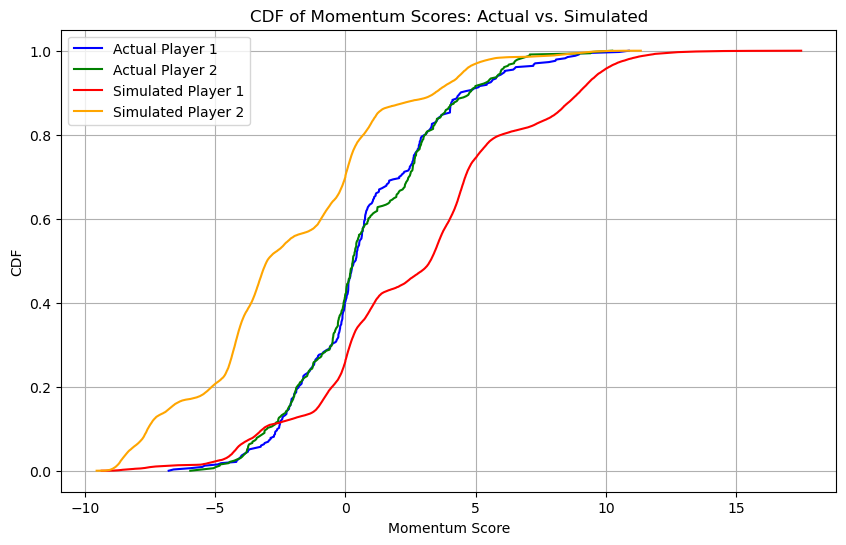

In [8]:
# 绘制CDF图
def plot_cdf(data, label, color):
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data) - 1)
    plt.plot(sorted_data, yvals, label=label, color=color)

plt.figure(figsize=(10, 6))
plot_cdf(actual_momentum_scores_1, 'Actual Player 1', 'blue')
plot_cdf(actual_momentum_scores_2, 'Actual Player 2', 'green')
plot_cdf(np.concatenate(simulated_scores_1).flatten(), 'Simulated Player 1', 'red')
plot_cdf(np.concatenate(simulated_scores_2).flatten(), 'Simulated Player 2', 'orange')

plt.xlabel('Momentum Score')
plt.ylabel('CDF')
plt.title('CDF of Momentum Scores: Actual vs. Simulated')
plt.legend()
plt.grid(True)
plt.show()


累积分布函数（CDF）图已绘制完成。在这个图表中，可以直观地比较实际玩家1和玩家2的势头得分（分别用蓝色和绿色线表示）与模拟玩家1和玩家2的势头得分（分别用红色和橙色线表示）之间的差异。

这种可视化有助于理解实际比赛中势头得分的分布情况与模拟比赛的差异，进一步支持了之前Kolmogorov-Smirnov测试的结果，即实际比赛中的势头转换在统计学上显著不同于随机情况。